In [150]:
from iotools import read_results
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from datetime import date
import os
from netCDF4 import Dataset
import pandas as pd
from iotools import read_AsciiGrid, write_AsciiGrid
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
from sklearn.metrics import mean_absolute_error as mae
from rasterio.plot import show
import rasterio
import xarray as xr

In [135]:
## reading simulation results
# reading the 1D results
outputfile_1d = r'D:\SpaFHy_2D_2021\results_1d.nc'
res_1d = xr.open_dataset(outputfile_1d)

# reading the 2D results
outputfile_2d = r'D:\SpaFHy_2D_2021\results_top.nc'
res_2d = xr.open_dataset(outputfile_2d)

# reading the top results
outputfile_top = r'D:\SpaFHy_2D_2021\results_top.nc'
res_top = xr.open_dataset(outputfile_top)

In [136]:
dates_spa = []
for d in range(len(res_1d['time'])):
    dates_spa.append(pd.to_datetime(str(res_1d['time'][d])[36:46]))
dates_spa = pd.to_datetime(dates_spa)

In [138]:
# reading SAR files
sar_tempfile = 'C:\SpaFHy_v1_Pallas_2D/obs/SAR_SM_PALLAS_2019_16M_TM35_CATCHMENT_TEMPINTERP.nc'
sar_temp = xr.open_dataset(sar_tempfile)

sar_spatfile = 'C:\SpaFHy_v1_Pallas_2D/obs/SAR_SM_PALLAS_2019_16M_TM35_CATCHMENT_TEMPINTERP_SPATINTERP.nc'
sar_spat = xr.open_dataset(sar_spatfile)

In [139]:
# simple tests for simulation files
try:
    res_1d['time'] in res_2d['time'] in res_top['time']
    print('Simulation times are a match!')
except ValueError:
    print('Simulation times DO NOT match!')
try:
    res_1d['lat'] in res_2d['lat'] in res_top['lat'] and res_1d['lon'] in res_2d['lon'] in res_top['lon']
    print('Simulation extents are a match!')
except ValueError:
    print('Simulation extents DO NOT match!') 
    
# simple tests for SAR files
try:
    sar_temp['time'] in sar_spat['time']
    print('SAR dates are a match!')
except ValueError:
    print('SAR dates do not match!')
try:
    sar_temp['lat'] in sar_spat['lat'] and sar_temp['lon'] in sar_spat['lon']
    print('SAR extents are a match!')
except ValueError:
    print('SAR extents DO NOT match!')
    
# simple tests for SAR + SpaFHy files
try:
    sar_temp['lat'] in sar_spat['lat'] in res_1d['lat'] and sar_temp['lon'] in sar_spat['lon'] in res_1d['lon']
    print('SAR and SpaFHy extents are a match!')
except ValueError:
    print('SAR and SpaFHy extents DO NOT match!')
try:
    sar_temp['time'] in sar_spat['time'] in res_1d['time']
    print('SAR and SpaFHy times are a match!')
except ValueError:
    print('SAR and SpaFHy times DO NOT match!')

Simulation times are a match!
Simulation extents are a match!
SAR dates are a match!
SAR extents are a match!
SAR and SpaFHy extents are a match!
SAR and SpaFHy times DO NOT match!


In [145]:
# READING POINT OBSERVATIONS

# 1 discharge
fn1 = r'C:\SpaFHy_v1_Pallas_2D\obs\Runoffs1d_SVEcatchments_mmd.csv'
q = pd.read_csv(fn1, sep=';', index_col=0, parse_dates=True)
q = q.loc[q.index.isin(dates_spa)]

# 2 swe
fn2 = r'C:\SpaFHy_v1_Pallas_2D\obs\swe_mm.csv'
swe = pd.read_csv(fn2, sep=';', index_col=0, parse_dates=True)

# 3 kenttärova soil moisture
fn3 = r'C:\SpaFHy_v1_Pallas_2D\obs\theta_kenttarova.csv'
theta = pd.read_csv(fn3, sep=';', index_col=0, parse_dates=True)

# 4 groundwater levels
fn4 = r'C:\SpaFHy_v1_Pallas_2D\obs\gw_levels.csv'
gw = pd.read_csv(fn4, sep=';', index_col=0, parse_dates=True)

# 5 evapotranspiration
fn5 = r'C:\SpaFHy_v1_Pallas\data\obs\ec_et.csv'
et = pd.read_csv(fn5, sep=';', index_col=0, parse_dates=True)

In [187]:
# parameters
today = date.today()
saveplots = True

# indexes for tighet plots
zx = np.arange(20, 171, 1)
zy = np.arange(20, 246, 1)

# defining important raster locations
ht = [118, 136] # hilltop
om = [46, 54]   # open mire

In [ ]:
# because we do not want to assess winter soil moisture (no soil freezing modelled)
when_snow = np.where(res_1d['canopy_snow_water_equivalent'][:,ht[0], ht[1]] > 0)
when_no_snow = np.where(res_1d['canopy_snow_water_equivalent'][:,ht[0], ht[1]] == 0)

res_1d['bucket_moisture_root'][when_snow] = np.nan
res_top['bucket_moisture_root'][when_snow] = np.nan
res_2d['bucket_moisture_root'][when_snow] = np.nan

In [185]:
# creating pd dataframes for those sim vs. obs we want scatterplots of
# soil moisture at hilltop and open mire

theta_ht = pd.DataFrame()
theta_om = pd.DataFrame()

theta_ht['res_2d_bucket_moisture_root'] = res_2d['bucket_moisture_root'][:,ht[0],ht[1]]
theta_ht['res_top_bucket_moisture_root'] = res_top['bucket_moisture_root'][:,ht[0],ht[1]]

theta_om['res_2d_bucket_moisture_root'] = res_2d['bucket_moisture_root'][:,om[0],om[1]]
theta_om['res_top_bucket_moisture_root'] = res_top['bucket_moisture_root'][:,om[0],om[1]]

theta_ht.index = dates_spa
theta_om.index = dates_spa

theta_ht['obs_moisture_root_mean'] = theta['mean_obs']

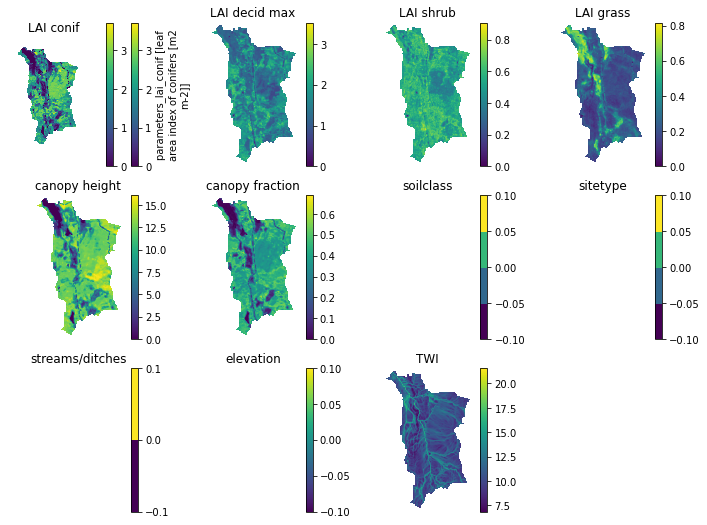

In [140]:
os.chdir(r'C:\SpaFHy_v1_Pallas_2D\figures')

# GIS PLOT

# Plotting
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12,9));
ax1 = axs[0][0]
ax2 = axs[0][1]
ax3 = axs[0][2]
ax4 = axs[0][3]

ax5 = axs[1][0]
ax6 = axs[1][1]
ax7 = axs[1][2]
ax8 = axs[1][3]

ax9 = axs[2][0]
ax10 = axs[2][1]
ax11 = axs[2][2]
ax12 = axs[2][3]

res_2d['parameters_lai_conif'].plot(ax=ax1)


im1 = ax1.imshow(res_2d['parameters_lai_conif'][20:250,20:165])
ax1.set_title('LAI conif')
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(res_2d['parameters_lai_decid_max'][20:250,20:165])
ax2.set_title('LAI decid max')
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(res_2d['parameters_lai_shrub'][20:250,20:165])
ax3.set_title('LAI shrub')
fig.colorbar(im3, ax=ax3)

im4 = ax4.imshow(res_2d['parameters_lai_grass'][20:250,20:165])
ax4.set_title('LAI grass')
fig.colorbar(im4, ax=ax4)

im5 = ax5.imshow(res_2d['parameters_hc'][20:250,20:165])
ax5.set_title('canopy height')
fig.colorbar(im5, ax=ax5)

im6 = ax6.imshow(res_2d['parameters_cf'][20:250,20:165], label='canopy fraction')
ax6.set_title('canopy fraction')
fig.colorbar(im6, ax=ax6)

cmapsoil = plt.get_cmap('viridis', 4)
im7 = ax7.imshow(res_top['parameters_soilclass'][20:250,20:165], cmap=cmapsoil)
ax7.set_title('soilclass')
fig.colorbar(im7, ax=ax7)

cmapsite = plt.get_cmap('viridis', 4)
im8 = ax8.imshow(res_top['parameters_sitetype'][20:250,20:165], cmap=cmapsite)
ax8.set_title('sitetype')
fig.colorbar(im8, ax=ax8)

cmapditch = plt.get_cmap('viridis', 2)
im9 = ax9.imshow(res_top['parameters_ditches'][20:250,20:165], cmap=cmapditch)
ax9.set_title('streams/ditches')
cbar = fig.colorbar(im9, ax=ax9)
cbar.ax.locator_params(nbins=1)

im10 = ax10.imshow(res_top['parameters_elevation'][20:250,20:165])
ax10.set_title('elevation')
fig.colorbar(im10, ax=ax10)

im11 = ax11.imshow(res_top['parameters_twi'][20:250,20:165])
ax11.set_title('TWI')
fig.colorbar(im11, ax=ax11)

#im12 = ax12.imshow(results_catch['parameters_twi'][20:250,20:165])
#ax12.set_title('shading coefficient')
#fig.colorbar(im12, ax=ax12)

ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off')
ax5.axis('off'); ax6.axis('off'); ax7.axis('off'); ax8.axis('off')
ax9.axis('off'); ax10.axis('off'); ax11.axis('off'); ax12.axis('off')

#plt.tight_layout()
#ax10.imshow(results_2d['parameters_twi'][20:250,20:165])

if saveplots == True:
        plt.savefig(f'GIS_rasters_{today}.pdf',bbox_inches='tight')
        plt.savefig(f'GIS_rasters_{today}.png',bbox_inches='tight')


ValueError: key of type tuple not found and not a MultiIndex

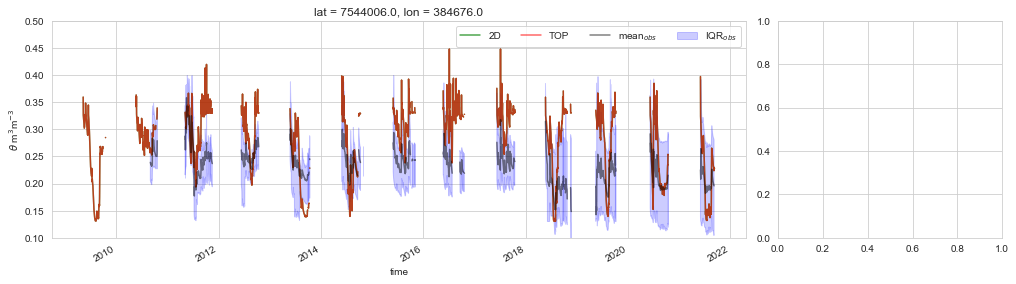

In [213]:
# TEMPORAL SOIL MOISTURE ET HILLTOP (KENTTÄROVA)
# Plotting

###
fig = plt.figure(constrained_layout=True, figsize=(14,7))
gs = fig.add_gridspec(2, 4)
sns.set_style('whitegrid')

ax1 = fig.add_subplot(gs[0, :3])
ax1.set_title('Hilltop')
im1 = res_2d['bucket_moisture_root'][:,ht[0], ht[1]].plot(ax=ax1, color='g', alpha=0.7, label='2D')
res_top['bucket_moisture_root'][:,ht[0], ht[1]].plot(ax=ax1, color='red', alpha=0.6, label='TOP')
ax1.plot(theta['mean_obs'],  'k', alpha=0.5, label=r'mean$_{obs}$')
ax1.fill_between(theta.index, theta['min'], theta['max'], color='blue', alpha=0.2, label=r'IQR$_{obs}$')

ax1.legend(ncol=5)

y = ax1.set_ylabel(r'$\theta$ m$^3$m$^{-3}$')
ax1.set_ylim(0.1,0.5)
#ax1.axes.get_xaxis().set_visible(False)

ax2 = fig.add_subplot(gs[0, 3])
im2 = sns.regplot(ax=ax2, x=theta_ht['res_2d_bucket_moisture_root'][:,ht[0], ht[1]], y=theta_ht['mean_obs'], scatter_kws={'s':50, 'alpha':0.2}, line_kws={"color": "red"})
#ax2.set(ylim=(0.1, 0.45))
#ax2.set(xlim=(0.1, 0.45))
#ax2.yaxis.tick_right()
#ax2.set_ylabel(r'$\theta_{obs}$ (m$^3$m$^{-3}$)')
#ax2.set_xlabel(r'$\theta_{mod}$ (m$^3$m$^{-3}$)')
'''

f3_ax3 = fig3.add_subplot(gs[1, :3])
f3_ax3.set_title('Open mire')
im2 = f3_ax3.plot(soilm['spa_l_2d_root'],  'g', alpha=0.7, label='2D')
f3_ax3.plot(soilm['spa_l_st_root'], 'red', alpha=0.6, label='stand/catch')
#f3_ax3.plot(soilm['spa_l_ca_root'],  'red', alpha=0.6, label='catch')
#ax2.plot(soilm.index[poi], 0.45, marker='o', mec='k', mfc='g', alpha=0.5, ms=8.0)
#ax2.axvline(soilm.index[poi], ymin=0, ymax=1, color='k', alpha=0.4)
f3_ax3.text(dates_spa[1], 1.03, 'Mire')
#ax2.title.set_text('Mire')
f3_ax3.set_ylim(0.4,1.0)
f3_ax3.set_ylabel(r'$\theta$ m$^3$m$^{-3}$')
#f3_ax3.legend(ncol=5)


#if saveplots == True:
#        plt.savefig(f'theta_model_ts_{today}.pdf')
#        plt.savefig(f'theta_model_ts_{today}.png')
'''